# Setting up

In [4]:
!gdown --id 1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
!gdown --id 1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
!gdown --id 1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
!mkdir ~/.demoji
!mv codes.json ~/.demoji/
!unzip wassa_dataset.zip
!rm wassa_dataset.zip
!pip install -qq demoji
!pip install -qq unidecode
!pip install -qq snowballstemmer

Downloading...
From: https://drive.google.com/uc?id=1up7d8aWd0H-QDN2konB_4oAwa4oHJQr2
To: /content/wassa_dataset.zip
100% 364k/364k [00:00<00:00, 45.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1doKr_6jKH1kwFFCL92LhAHnDwHVmCQVK
To: /content/emoticons.csv
100% 6.02k/6.02k [00:00<00:00, 3.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mUoiYzyUs6ihlmkqskdPPgo0O1ainWqw
To: /content/codes.json
100% 216k/216k [00:00<00:00, 57.2MB/s]
mkdir: cannot create directory ‘/root/.demoji’: File exists
Archive:  wassa_dataset.zip
replace wassa_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wassa_train.csv         
replace wassa_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wassa_test.csv          
replace wassa_val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wassa_val.csv           


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 
import numpy as np
import itertools
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle
import snowballstemmer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [6]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

# Loading the dataset

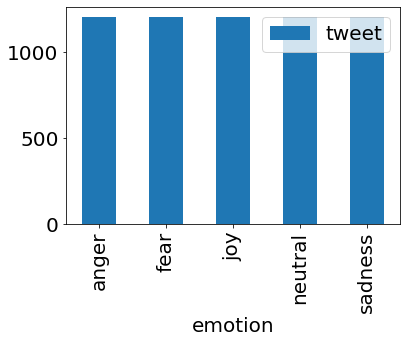

         tweet
emotion       
anger     1200
fear      1200
joy       1200
neutral   1200
sadness   1200


In [36]:
df_train = pd.read_csv("wassa_train.csv")
df_val = pd.read_csv("wassa_val.csv")
df_test = pd.read_csv("wassa_test.csv")
n_samples = df_train[["tweet", "emotion"]].groupby("emotion").count()
n_samples.plot(kind="bar")
plt.show()
print(n_samples)

In [37]:
df_train = df_train.query("emotion != 'neutral'")
df_val = df_val.query("emotion != 'neutral'")
df_test = df_test.query("emotion != 'neutral'")

In [38]:
labels = ['joy', 'anger', 'fear', 'sadness']

# Useful functions

In [39]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 20})
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



In [40]:
def preprocess_text(text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")

    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "

    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

In [41]:
def preprocess_text_list(text_list, stop_words):
  for i,text in enumerate(text_list):
    text_list[i] = preprocess_text(text_list[i], stop_words)

In [42]:
def pickle_object(object, location):
    filehandler = open(location, "wb")
    pickle.dump(object, filehandler)
    filehandler.close()

def pickle_load_object(location):
    file = open(location, 'rb')
    object = pickle.load(file)
    file.close()
    return object

In [43]:
def compute_metrics(y_true, predictions):
  average = "macro"
  acc = accuracy_score(y_true, predictions)
  precision = precision_score(y_true, predictions, average=average)
  recall = recall_score(y_true, predictions, average=average)
  f1 = f1_score(y_true, predictions, average=average)
  print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")


# Preprocessing

In [44]:
train_texts = df_train["tweet"].tolist()
val_texts = df_val["tweet"].tolist()
test_texts = df_test["tweet"].tolist()


train_labels = df_train["emotion"].tolist()
val_labels = df_val["emotion"].tolist()
test_labels = df_test["emotion"].tolist()

train_labels[:10]

['joy',
 'anger',
 'anger',
 'joy',
 'sadness',
 'sadness',
 'anger',
 'sadness',
 'fear',
 'sadness']

## English

In [45]:
stop_words = stopwords.words("english")  # loads english stopwords

preprocess_text_list(train_texts, stop_words)
preprocess_text_list(val_texts,  stop_words)
preprocess_text_list(test_texts, stop_words)

train_texts[:10]

['kinda wish watch mischiev kiss play kiss ',
 'forget mention bought dreamboy ticket ',
 'move clip youtub tonight vigil held tulsa metropolitan baptist church  terencecruth  justic  sad ',
 'make success  happi forev ',
 'standard candic start show pout  startasyoumeantogoon  gbbo ',
 '  she would frown bit  fold arms whi everi time m need assist someon expect lil  ',
 'sorri burst bubbl never illus ',
 'sad even  clear harvey s cage belong  final  goodby littl man    depress ',
 'specif area  care like   cloth  much mother s dismay  ',
 'well  s need sulk  alway request song  know  ']

# Encoding

In [46]:
 # Vectorizing texts
 vectorizer = TfidfVectorizer()
 vectorizer.fit(train_texts)

TfidfVectorizer()

In [47]:
vectorized_train_texts = vectorizer.transform(train_texts)
vectorized_val_texts = vectorizer.transform(val_texts)
vectorized_test_texts = vectorizer.transform(test_texts)

In [48]:
# label encoding
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# SVM

## Defying the model

In [49]:
svm_model = svm.SVC(probability=True)
svm_model.fit(vectorized_train_texts, encoded_train_labels)

SVC(probability=True)

## Validation

In [50]:
y_pred = svm_model.predict_log_proba(vectorized_val_texts)
y_pred

array([[-6.09911318e+00, -3.18524750e+00, -2.38286617e-01,
        -1.78135187e+00],
       [-6.64179878e+00, -5.12766384e-03, -6.52765829e+00,
        -6.05443200e+00],
       [-2.26115694e+01, -8.80175559e-06, -1.52252907e+01,
        -1.16687178e+01],
       ...,
       [-1.45576422e-02, -4.56009880e+00, -7.44418847e+00,
        -5.68211800e+00],
       [-5.23417179e+00, -6.54305158e+00, -2.53765146e-02,
        -4.00162435e+00],
       [-5.57794483e+00, -3.35708155e+00, -3.94308623e+00,
        -5.97557288e-02]])

In [51]:
acc = accuracy_score(encoded_val_labels, np.argmax(y_pred, axis=1))
precision = precision_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
recall = recall_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
f1 = f1_score(encoded_val_labels, np.argmax(y_pred, axis=1), average="micro")
print(f"Model has acc = {acc}\n, precision = {precision}\n, recall = {recall}\n, f1_score = {f1}\n")

Model has acc = 0.925
, precision = 0.925
, recall = 0.925
, f1_score = 0.925



## Testing

In [52]:
y_pred = svm_model.predict(vectorized_test_texts)

In [53]:
compute_metrics(encoded_test_labels, y_pred)


Model has acc = 0.9066666666666666
, precision = 0.9086666803885026
, recall = 0.9066666666666667
, f1_score = 0.9070226212510961



In [54]:
print(classification_report(encoded_test_labels, y_pred, target_names=labels))

              precision    recall  f1-score   support

         joy       0.93      0.91      0.92       150
       anger       0.86      0.90      0.88       150
        fear       0.96      0.89      0.92       150
     sadness       0.89      0.93      0.91       150

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



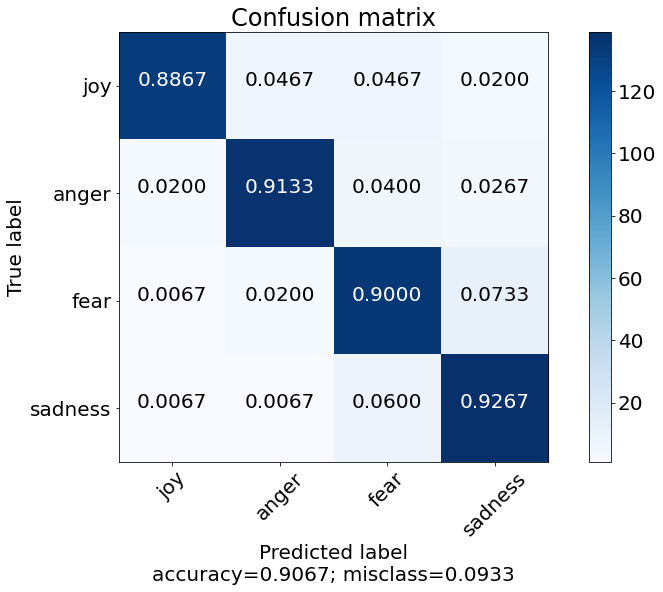

In [55]:
y_pred = label_encoder.inverse_transform(y_pred)
cm = confusion_matrix(test_labels, y_pred, labels=labels)
plot_confusion_matrix(cm, labels)

## Building SVM class

In [56]:
class SVM_model:
  def __init__(self, classifier, encoder, stop_words, vectorizer):
    self._classifier = classifier
    self._encoder = encoder
    self._stop_words = stop_words
    self._vectorizer = vectorizer
  
  def _preprocess_text(self, text, stop_words):
    # make lowercase and strip empty spaces
    result = text.lower()
    # strip extra spaces
    result = result.strip()
    # eliminate URLs
    result = re.result = re.sub(r"http\S+", "", result)
    # eliminate email addresses
    result = re.sub('\S*@\S*\s?', '', result)
    # strip diacritics
    result = unidecode.unidecode(result)
    # english stopwords
    word_list = word_tokenize(result)
    # english stemmer
    ps = SnowballStemmer("english")
    stemmed_sentence = ""
    for word in word_list:
        if word not in stop_words:
            stemmed_sentence += ps.stem(word)
            stemmed_sentence += " "
    result = stemmed_sentence
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    result = ''.join(filter(whitelist.__contains__, result))
    result = ''.join([i for i in result if not i.isdigit()])
    return result

  def _vectorize_texts(self, texts):
    vectorized_texts = []
    for text in texts:
      processed_text = self._preprocess_text(text, self._stop_words)
      vectorized_texts.append(processed_text)
    return self._vectorizer.transform(vectorized_texts)

  def detect_emotions_with_labels(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    predictions  = list(self._encoder.inverse_transform(np.argmax(predictions, axis=1)))
    return predictions

  def detect_emotions_with_proba(self, texts):
    vectorized_texts = self._vectorize_texts(texts)
    predictions = self._classifier.predict_log_proba(vectorized_texts)
    return predictions

  def proba_to_labels(self, proba):
      labels  = list(self._encoder.inverse_transform(np.argmax(proba, axis=1)))
      return labels

In [57]:
svm_cls = SVM_model(svm_model, label_encoder, stop_words, vectorizer)

In [58]:
predictions = svm_cls.detect_emotions_with_labels(val_texts)
acc = accuracy_score(val_labels, predictions)
acc

0.9216666666666666

## Testing


In [59]:
preds = svm_cls.detect_emotions_with_labels(test_texts)

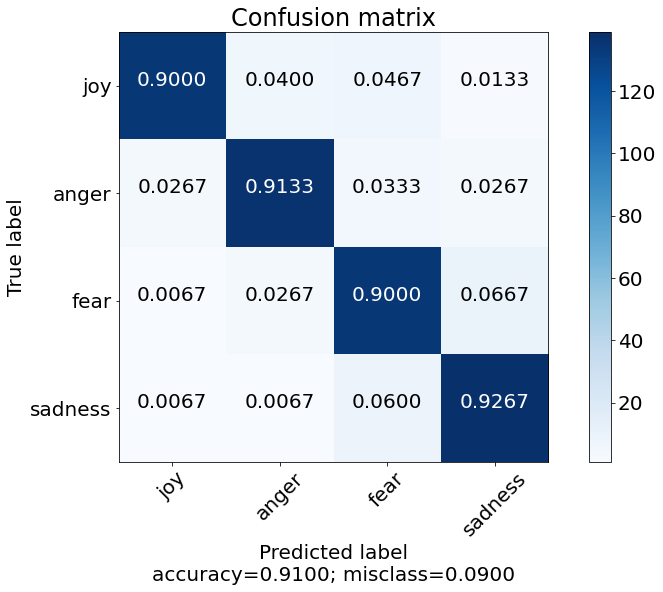

In [60]:
cm = confusion_matrix(test_labels, preds, labels=labels)
plot_confusion_matrix(cm, labels)

## Saving the model

In [61]:
pickle_object(svm_cls, "svm_model.obj")

In [62]:
svm_cls = pickle_load_object("svm_model.obj")

In [63]:
preds = svm_cls.detect_emotions_with_labels(test_texts)

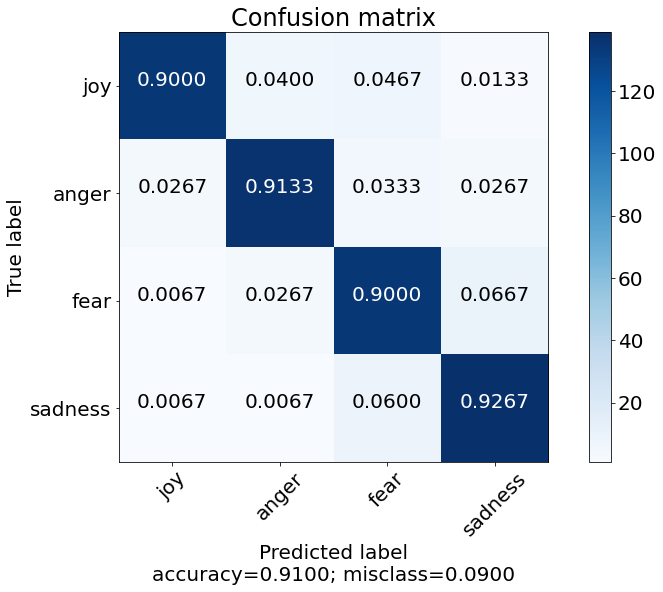

In [64]:
cm = confusion_matrix(test_labels, preds, labels=labels)
plot_confusion_matrix(cm, labels)

# Multinomial Naive bayes

In [ ]:
mnb = MultinomialNB(alpha=1)
mnb.fit(vectorized_train_texts, encoded_train_labels)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [ ]:
preds_val = mnb.predict(vectorized_val_texts)

In [ ]:
preds_test = mnb.predict(vectorized_test_texts)

In [ ]:
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.8213333333333334
, precision = 0.8207896296291688
, recall = 0.8213333333333332
, f1_score = 0.8172448944929753



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.8026666666666666
, precision = 0.8014707230572864
, recall = 0.8026666666666668
, f1_score = 0.8006028750562351



# Gaussian Naive Bayes

In [ ]:
gaussian_nb = GaussianNB(var_smoothing=5e-1)
gaussian_nb

GaussianNB(priors=None, var_smoothing=0.5)

In [ ]:
x = vectorized_train_texts.toarray()

In [ ]:
gaussian_nb.fit(x, encoded_train_labels)

GaussianNB(priors=None, var_smoothing=0.5)

In [ ]:
preds_val = gaussian_nb.predict(vectorized_val_texts.toarray())
preds_test = gaussian_nb.predict(vectorized_test_texts.toarray())

In [ ]:
compute_metrics(encoded_val_labels, preds_val)

Model has acc = 0.7253333333333334
, precision = 0.7694661255371684
, recall = 0.7253333333333333
, f1_score = 0.732045853048164



In [ ]:
compute_metrics(encoded_test_labels, preds_test)

Model has acc = 0.7306666666666667
, precision = 0.7806889160928956
, recall = 0.7306666666666667
, f1_score = 0.738510572433856

